In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gprofiler import GProfiler
import os

# Create output directory
os.makedirs('results/enrichment', exist_ok=True)

print("Libraries loaded successfully!")

Libraries loaded successfully!


# Read data 

In [3]:
# Load all DE results
de_results = pd.read_csv('results/tables/deseq2_all_results_genesymbol.csv')

print(f"Total genes in DE results: {len(de_results)}")
print(f"Columns: {list(de_results.columns)}")
de_results.head()

Total genes in DE results: 922
Columns: ['gene_symbol', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj']


,gene_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,WDR35,778.864531,-1.798423,0.099426,-18.088132,3.952598e-73,3.644296e-70
1,EPAS1,8542.203648,0.902767,0.054622,16.527623,2.321181e-61,1.044607e-58
2,CRIM1,11400.864532,0.924552,0.056018,16.504615,3.398940e-61,1.044607e-58
3,EFR3B,1491.642425,1.060645,0.080901,13.110412,2.870347e-39,6.616150e-37
4,LTBP1,324.199219,1.847760,0.151279,12.214240,2.609277e-34,4.811507e-32


# part2 Listt the significant genes 

In [5]:
# Significance thresholds
PADJ_THRESHOLD = 0.05
LOG2FC_THRESHOLD = 1  # |log2FC| > 1 means >2-fold change

# Filter for significant genes
sig_genes = de_results[
    (de_results['padj'] < PADJ_THRESHOLD) &
    (de_results['log2FoldChange'].abs() > LOG2FC_THRESHOLD)
].copy()

# Separate upregulated and downregulated genes
up_genes = sig_genes[sig_genes['log2FoldChange'] > 0]['gene_symbol'].tolist()
down_genes = sig_genes[sig_genes['log2FoldChange'] < 0]['gene_symbol'].tolist()
all_sig_genes = sig_genes['gene_symbol'].tolist()

print(f"Significant genes (padj < {PADJ_THRESHOLD}, |log2FC| > {LOG2FC_THRESHOLD}):")
print(f"  Total: {len(all_sig_genes)}")
print(f"  Upregulated in KO: {len(up_genes)}")
print(f"  Downregulated in KO: {len(down_genes)}")

Significant genes (padj < 0.05, |log2FC| > 1):
  Total: 41
  Upregulated in KO: 32
  Downregulated in KO: 9


# Part 3: Run GO Enrichment Analysis

In [7]:
# Initialize g:Profiler
gp = GProfiler(return_dataframe=True)

def run_enrichment(gene_list, name, sources=['GO:BP', 'GO:MF', 'GO:CC']):
    """
    Run g:Profiler enrichment analysis on a gene list.

    Parameters:
    - gene_list: list of gene IDs
    - name: description for logging
    - sources: databases to query (GO:BP, GO:MF, GO:CC, KEGG, REAC, etc.)

    Returns:
    - DataFrame with enrichment results
    """
    if len(gene_list) == 0:
        print(f"Warning: {name} gene list is empty!")
        return pd.DataFrame()

    print(f"\nRunning enrichment for {name} ({len(gene_list)} genes)...")

    results = gp.profile(
        organism='hsapiens',
        query=gene_list,
        sources=sources,
        user_threshold=0.05,  # Significance threshold
        significance_threshold_method='fdr',  # Multiple testing correction
        no_evidences=False
    )

    if len(results) > 0:
        print(f"  Found {len(results)} significant terms")
    else:
        print(f"  No significant terms found")

    return results

# Run GO enrichment for all three gene sets

In [8]:
# Run GO enrichment analysis
go_all = run_enrichment(all_sig_genes, "All significant genes", sources=['GO:BP', 'GO:MF', 'GO:CC'])
go_up = run_enrichment(up_genes, "Upregulated genes", sources=['GO:BP', 'GO:MF', 'GO:CC'])
go_down = run_enrichment(down_genes, "Downregulated genes", sources=['GO:BP', 'GO:MF', 'GO:CC'])


Running enrichment for All significant genes (41 genes)...
  Found 21 significant terms

Running enrichment for Upregulated genes (32 genes)...
  Found 27 significant terms

Running enrichment for Downregulated genes (9 genes)...
  Found 11 significant terms


# Explore GO 

In [9]:
# View columns in results
if len(go_all) > 0:
    print("Columns in enrichment results:")
    print(go_all.columns.tolist())
    print("\nTop 10 GO terms for all significant genes:")
    display(go_all[['source', 'native', 'name', 'p_value', 'intersection_size']].head(10))

Columns in enrichment results:
['source', 'native', 'name', 'p_value', 'significant', 'description', 'term_size', 'query_size', 'intersection_size', 'effective_domain_size', 'precision', 'recall', 'query', 'parents', 'intersections', 'evidences']

Top 10 GO terms for all significant genes:


,source,native,name,p_value,intersection_size
0,GO:MF,GO:0030546,signaling receptor activator activity,0.006174,7
1,GO:MF,GO:0048018,receptor ligand activity,0.006174,7
2,GO:MF,GO:0019838,growth factor binding,0.006174,4
3,GO:MF,GO:0019966,interleukin-1 binding,0.006174,2
4,GO:MF,GO:0030545,signaling receptor regulator activity,0.006174,7
5,GO:MF,GO:0060089,molecular transducer activity,0.007159,12
6,GO:MF,GO:0038023,signaling receptor activity,0.007159,12
7,GO:MF,GO:0005102,signaling receptor binding,0.009826,10
8,GO:MF,GO:0070002,glutamic-type peptidase activity,0.034723,1
9,GO:MF,GO:0046812,host cell surface binding,0.034723,1


In [10]:
go_all

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,intersections,evidences
0,GO:MF,GO:0030546,signaling receptor activator activity,0.006174,True,"""The function of interacting (directly or indi...",546,37,7,20246,0.189189,0.012821,query_1,"[GO:0030545, GO:0038023, GO:0140677]","[LTBP1, TGFA, IL1RN, INHBB, IGFBP5, WNT10A, GKN1]","[[IDA], [IDA, IBA, IEA], [IEA], [IBA, TAS, IEA..."
1,GO:MF,GO:0048018,receptor ligand activity,0.006174,True,"""The activity of a gene product that interacts...",539,37,7,20246,0.189189,0.012987,query_1,"[GO:0005102, GO:0030546]","[LTBP1, TGFA, IL1RN, INHBB, IGFBP5, WNT10A, GKN1]","[[IDA], [IDA, IBA, IEA], [IEA], [IBA, TAS, IEA..."
2,GO:MF,GO:0019838,growth factor binding,0.006174,True,"""Binding to a growth factor, proteins or polyp...",134,37,4,20246,0.108108,0.029851,query_1,[GO:0005515],"[LTBP1, IL1R1, IL1RN, IGFBP5]","[[IPI, IEA], [IBA, IEA], [IDA, IBA, TAS], [IPI..."
3,GO:MF,GO:0019966,interleukin-1 binding,0.006174,True,"""Binding to interleukin-1."" [GOC:jl, ISBN:0198...",9,37,2,20246,0.054054,0.222222,query_1,"[GO:0019838, GO:0019955]","[IL1R1, IL1RN]","[[IBA, IEA], [IDA, IBA, TAS]]"
4,GO:MF,GO:0030545,signaling receptor regulator activity,0.006174,True,"""Binds to and modulates the activity of a rece...",583,37,7,20246,0.189189,0.012007,query_1,"[GO:0038023, GO:0098772]","[LTBP1, TGFA, IL1RN, INHBB, IGFBP5, WNT10A, GKN1]","[[IDA], [IDA, IBA, IEA], [IDA, IBA, TAS, IEA],..."
5,GO:MF,GO:0060089,molecular transducer activity,0.007159,True,"""A compound molecular function in which an eff...",2053,37,12,20246,0.324324,0.005845,query_1,[GO:0003674],"[LTBP1, TGFA, IL1R1, ADRA2B, IL1RN, INHBB, MAR...","[[IDA, NAS], [IDA, IBA, IEA], [IDA, IBA, TAS, ..."
6,GO:MF,GO:0038023,signaling receptor activity,0.007159,True,"""Receiving a signal and transmitting it in the...",2053,37,12,20246,0.324324,0.005845,query_1,[GO:0060089],"[LTBP1, TGFA, IL1R1, ADRA2B, IL1RN, INHBB, MAR...","[[IDA, NAS], [IDA, IBA, IEA], [IDA, IBA, TAS, ..."
7,GO:MF,GO:0005102,signaling receptor binding,0.009826,True,"""Binding to one or more specific sites on a re...",1521,37,10,20246,0.270270,0.006575,query_1,[GO:0005515],"[LTBP1, TGFA, COL4A3, IL1R1, IL1RN, INHBB, MAR...","[[IDA], [IDA, IBA, IEA], [IDA, TAS], [IPI], [I..."
8,GO:MF,GO:0070002,glutamic-type peptidase activity,0.034723,True,"""Catalysis of the hydrolysis of peptide bonds ...",1,37,1,20246,0.027027,1.000000,query_1,[GO:0008233],[ASTL],"[[ISS, IEA]]"
9,GO:MF,GO:0046812,host cell surface binding,0.034723,True,"""Binding to the surface of a host cell."" [GOC:ai]",1,37,1,20246,0.027027,1.000000,query_1,[GO:0005488],[INHBB],[[TAS]]


In [11]:
# View columns in results
if len(go_down) > 0:
    print("Columns in enrichment results:")
    print(go_all.columns.tolist())
    print("\nTop 10 GO terms for all significant genes:")
    display(go_all[['source', 'native', 'name', 'p_value', 'intersection_size']].head(10))

Columns in enrichment results:
['source', 'native', 'name', 'p_value', 'significant', 'description', 'term_size', 'query_size', 'intersection_size', 'effective_domain_size', 'precision', 'recall', 'query', 'parents', 'intersections', 'evidences']

Top 10 GO terms for all significant genes:


,source,native,name,p_value,intersection_size
0,GO:MF,GO:0030546,signaling receptor activator activity,0.006174,7
1,GO:MF,GO:0048018,receptor ligand activity,0.006174,7
2,GO:MF,GO:0019838,growth factor binding,0.006174,4
3,GO:MF,GO:0019966,interleukin-1 binding,0.006174,2
4,GO:MF,GO:0030545,signaling receptor regulator activity,0.006174,7
5,GO:MF,GO:0060089,molecular transducer activity,0.007159,12
6,GO:MF,GO:0038023,signaling receptor activity,0.007159,12
7,GO:MF,GO:0005102,signaling receptor binding,0.009826,10
8,GO:MF,GO:0070002,glutamic-type peptidase activity,0.034723,1
9,GO:MF,GO:0046812,host cell surface binding,0.034723,1


## KEGG Pathway

In [12]:
# Run KEGG pathway enrichment
kegg_all = run_enrichment(all_sig_genes, "All significant genes (KEGG)", sources=['KEGG'])
kegg_up = run_enrichment(up_genes, "Upregulated genes (KEGG)", sources=['KEGG'])
kegg_down = run_enrichment(down_genes, "Downregulated genes (KEGG)", sources=['KEGG'])


Running enrichment for All significant genes (KEGG) (41 genes)...
  No significant terms found

Running enrichment for Upregulated genes (KEGG) (32 genes)...
  No significant terms found

Running enrichment for Downregulated genes (KEGG) (9 genes)...
  No significant terms found


# Plot

In [13]:
def plot_enrichment_bar(results, title, top_n=15, figsize=(10, 8)):
    """
    Create a bar plot of top enriched terms.
    """
    if len(results) == 0:
        print(f"No results to plot for: {title}")
        return None

    # Get top N results
    plot_data = results.head(top_n).copy()
    plot_data = plot_data.sort_values('p_value', ascending=True)

    # Create -log10(p-value) for better visualization
    plot_data['-log10(p)'] = -np.log10(plot_data['p_value'])

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Color by source (GO:BP, GO:MF, GO:CC, KEGG)
    colors = {'GO:BP': '#1f77b4', 'GO:MF': '#ff7f0e', 'GO:CC': '#2ca02c', 'KEGG': '#d62728'}
    bar_colors = [colors.get(s, '#7f7f7f') for s in plot_data['source']]

    # Create horizontal bar plot
    bars = ax.barh(range(len(plot_data)), plot_data['-log10(p)'], color=bar_colors)

    # Customize plot
    ax.set_yticks(range(len(plot_data)))
    ax.set_yticklabels(plot_data['name'], fontsize=9)
    ax.set_xlabel('-log10(p-value)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Add gene count labels
    for i, (bar, count) in enumerate(zip(bars, plot_data['intersection_size'])):
        ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                f'n={count}', va='center', fontsize=8)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=c, label=s) for s, c in colors.items() if s in plot_data['source'].values]
    if legend_elements:
        ax.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    return fig


def plot_enrichment_dot(results, title, top_n=15, figsize=(10, 8)):
    """
    Create a dot plot of top enriched terms (similar to clusterProfiler style).
    """
    if len(results) == 0:
        print(f"No results to plot for: {title}")
        return None

    plot_data = results.head(top_n).copy()

    # Calculate gene ratio
    plot_data['GeneRatio'] = plot_data['intersection_size'] / plot_data['query_size']
    plot_data['-log10(p)'] = -np.log10(plot_data['p_value'])

    fig, ax = plt.subplots(figsize=figsize)

    scatter = ax.scatter(
        plot_data['GeneRatio'],
        range(len(plot_data)),
        s=plot_data['intersection_size'] * 10,  # Size by gene count
        c=plot_data['-log10(p)'],  # Color by significance
        cmap='viridis',
        alpha=0.7,
        edgecolors='black',
        linewidths=0.5
    )

    ax.set_yticks(range(len(plot_data)))
    ax.set_yticklabels(plot_data['name'], fontsize=9)
    ax.set_xlabel('Gene Ratio', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, label='-log10(p-value)')

    # Add size legend
    sizes = [5, 10, 20]
    for size in sizes:
        ax.scatter([], [], s=size*10, c='gray', alpha=0.7, label=f'{size} genes')
    ax.legend(loc='lower right', title='Gene Count')

    plt.tight_layout()
    return fig

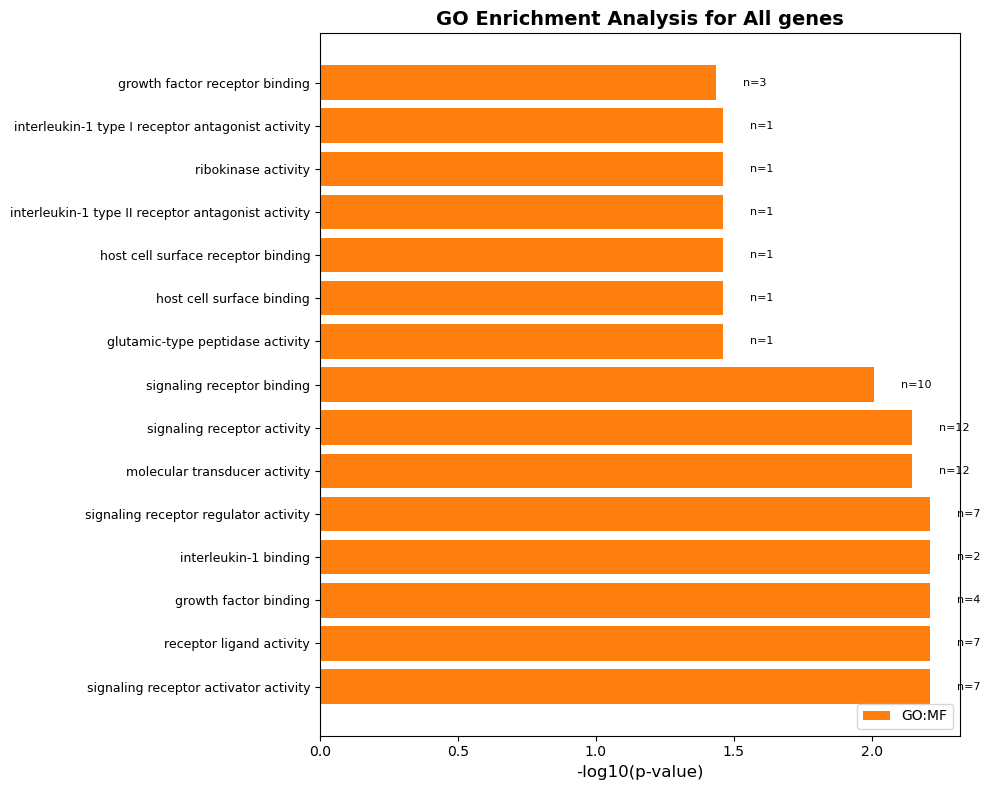

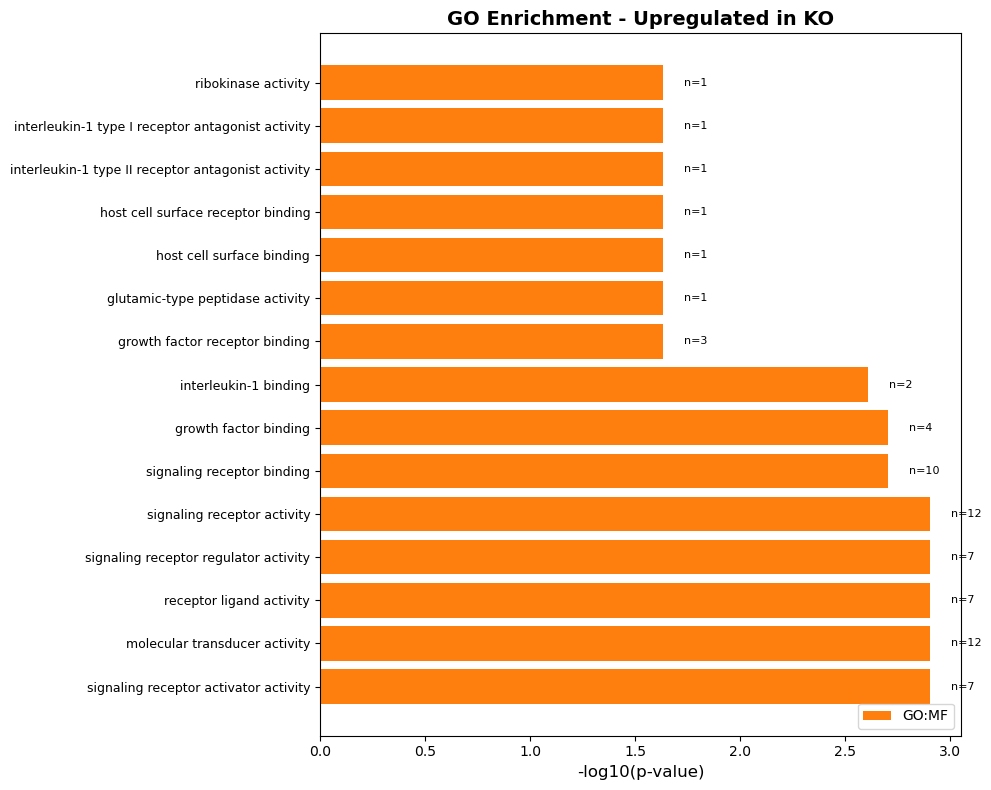

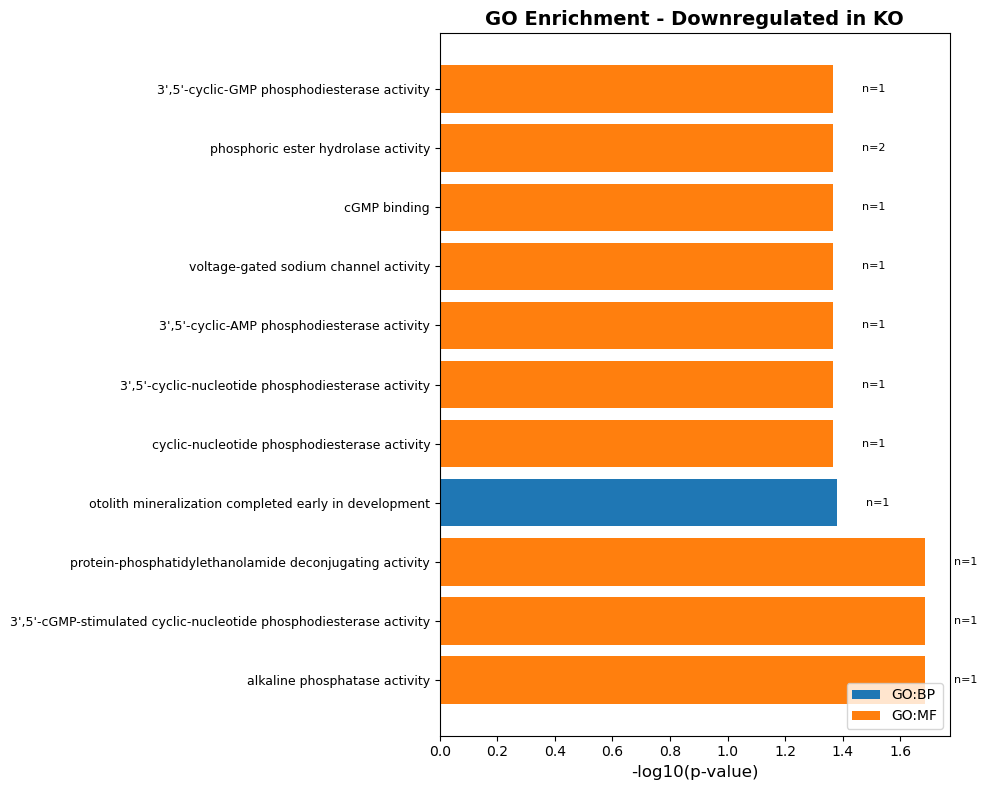

In [14]:
# Plot GO enrichment - All significant genes
fig = plot_enrichment_bar(go_all, 'GO Enrichment Analysis for All genes')
if fig:
    fig.savefig('results/enrichment/go_all_genes_bar.png', dpi=150, bbox_inches='tight')
    plt.show()
    
# Plot GO enrichment - Upregulated genes
fig = plot_enrichment_bar(go_up, 'GO Enrichment - Upregulated in KO')
if fig:
    fig.savefig('results/enrichment/go_upregulated_bar.png', dpi=150, bbox_inches='tight')
    plt.show()
# Plot GO enrichment - Downregulated genes
fig = plot_enrichment_bar(go_down, 'GO Enrichment - Downregulated in KO')
if fig:
    fig.savefig('results/enrichment/go_downregulated_bar.png', dpi=570, bbox_inches='tight')
    plt.show()

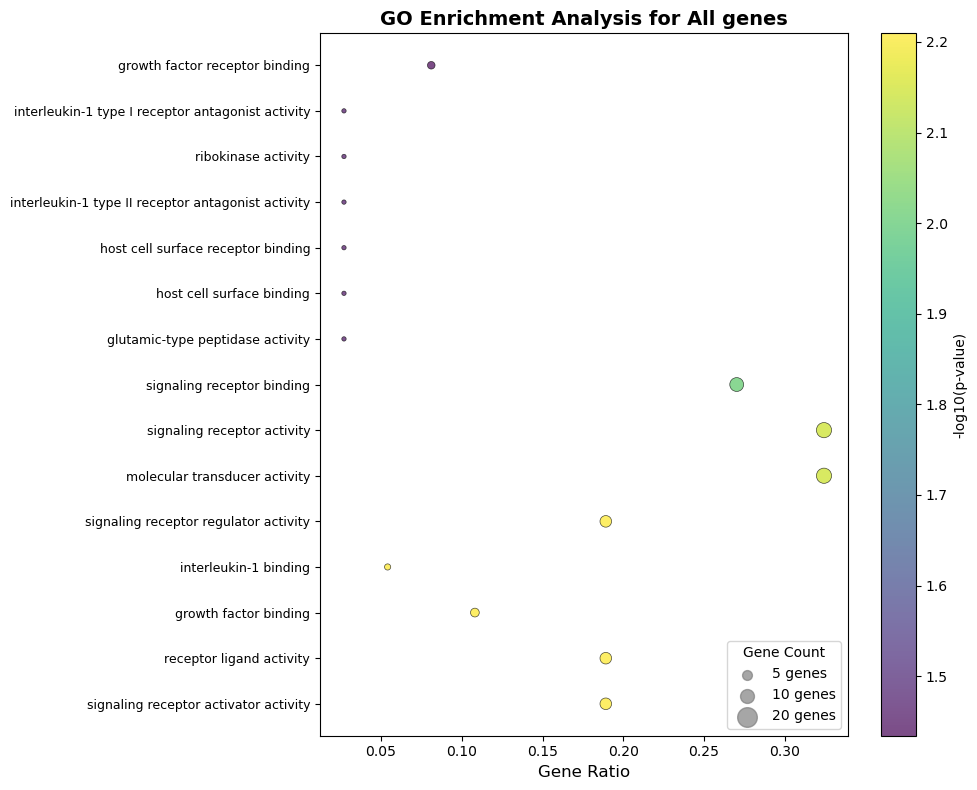

In [15]:
# Create dot plots (publication-style)
fig = plot_enrichment_dot(go_all, 'GO Enrichment Analysis for All genes')
if fig:
    fig.savefig('results/enrichment/go_all_genes_dot.png', dpi=150, bbox_inches='tight')
    plt.show()

In [24]:
# Create a summary of enrichment analysis
summary = f"""
============================================
Enrichment Analysis Summary
============================================

Input:
  Total significant genes: {len(all_sig_genes)}
  Upregulated genes: {len(up_genes)}
  Downregulated genes: {len(down_genes)}

Significance thresholds:
  padj < {PADJ_THRESHOLD}
  |log2FoldChange| > {LOG2FC_THRESHOLD}

GO Enrichment Results:
  All genes: {len(go_all)} significant terms
  Upregulated: {len(go_up)} significant terms
  Downregulated: {len(go_down)} significant terms

KEGG Pathway Results:
  All genes: {len(kegg_all)} significant pathways
  Upregulated: {len(kegg_up)} significant pathways
  Downregulated: {len(kegg_down)} significant pathways

Output files saved to: results/enrichment/
============================================
"""
print(summary)

# Save summary to file
with open('results/enrichment/analysis_summary.txt', 'w') as f:
    f.write(summary)



Enrichment Analysis Summary

Input:
  Total significant genes: 41
  Upregulated genes: 32
  Downregulated genes: 9

Significance thresholds:
  padj < 0.05
  |log2FoldChange| > 1

GO Enrichment Results:
  All genes: 21 significant terms
  Upregulated: 27 significant terms
  Downregulated: 11 significant terms

KEGG Pathway Results:
  All genes: 0 significant pathways
  Upregulated: 0 significant pathways
  Downregulated: 0 significant pathways

Output files saved to: results/enrichment/



# Try different enrichment algorithms


In [18]:
pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.2/605.2 kB 2.4 MB/s  0:00:0036m-:--:--
Note: you may need to restart the kernel to use updated packages.


In [24]:
import gseapy as gp

 
sig_genes_list = all_sig_genes

# Enrichr GO Biological Process
enr_go = gp.enrichr(gene_list=sig_genes_list,
                    gene_sets=['GO_Biological_Process_2021'],
                    organism='Human',
                    cutoff=0.5, # no results with 0.05 threshold
                    outdir='enrichr_go_results')

# Enrichr KEGG
enr_kegg = gp.enrichr(gene_list=sig_genes_list,
                      gene_sets=['KEGG_2021_Human'],
                      organism='Human',
                      cutoff=0.5,
                      outdir='enrichr_kegg_results')

# View top results
enr_go.results.head()


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,positive regulation of signaling receptor acti...,2/37,0.002609,0.150923,0,0,29.192674,173.656654,TGFA;ADRA2B
1,GO_Biological_Process_2021,intraciliary transport involved in cilium asse...,2/40,0.003044,0.150923,0,0,26.883941,155.779483,KIF3C;WDR35
2,GO_Biological_Process_2021,action potential (GO:0001508),2/45,0.003839,0.150923,0,0,23.751938,132.122005,SCN9A;SLC4A3
3,GO_Biological_Process_2021,sensory organ development (GO:0007423),2/56,0.005887,0.150923,0,0,18.903134,97.066961,WNT10A;MYO7B
4,GO_Biological_Process_2021,positive regulation of protein phosphorylation...,4/371,0.006868,0.150923,0,0,5.771264,28.745709,MARCO;INHBB;MAPRE3;PROM2


In [32]:
rnk_df = de_results[['gene_symbol', 'log2FoldChange']].dropna().sort_values('log2FoldChange', ascending=False)

pre_res_kegg = gp.prerank(
    rnk=rnk_df,
    gene_sets='KEGG_2021_Human',
    outdir='gsea_kegg_results',
    permutation_num=100
)

pre_res_go = gp.prerank(
    rnk=rnk_df,
    gene_sets='GO_Biological_Process_2021',
    outdir='gsea_go_results',
    permutation_num=100
)


In [35]:
pre_res_kegg.res2d.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,PI3K-Akt signaling pathway,0.777208,1.596648,0.040541,0.17479,0.09,6/15,6.94%,TGFA;ITGB6;COL6A3;COL4A3;COL4A4;FN1
1,prerank,Human papillomavirus infection,0.706553,1.585477,0.027397,0.087395,0.09,7/20,6.94%,WNT10A;ITGB6;COL6A3;COL4A3;HES6;COL4A4;FN1
2,prerank,Pathways in cancer,0.658743,1.557795,0.037037,0.07619,0.11,9/30,13.23%,WNT10A;TGFA;COL4A3;COL4A4;EPAS1;FN1;STAT4;RASG...
3,prerank,Alzheimer disease,0.501428,1.143179,0.324324,0.605042,0.66,1/21,0.65%,WNT10A
4,prerank,Regulation of actin cytoskeleton,0.534517,1.139601,0.378788,0.49479,0.67,4/15,19.20%,ITGB6;FN1;ITGAV;CXCR4


In [ ]:
# with different tools, we find some Kegg pathways meaning at the end it depends in the tools and the thresholds used. The highest thresshold give more results which may not accurate but also the number of genes are too small 